Signal Region Split with Preselection Neural Network
--

The $H\to \tau\tau$ channel is dominated by large backgrounds, and the inclusive space contains phase space regions with little to no signal. These regions can be used to constrain backgrounds using binned traditional fits, whereas the phase space regions with non-negligible signal can be probed with NSBI for improving sensitivity.

In this notebook we train a Neural Network to predict a score observable:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_{sig} P_{sig} (x)}{\sum_{bkg} P_{bkg}(x)} \right]$$

that can be used to separate signal-rich regions from background-rich regions. Here $P_i$ are the outputs from a multi-class classifier.

In [18]:
import os, sys, pathlib, importlib
sys.path.append('../')

# Load the package and modules for training and plotting
import nsbi_common_utils
from nsbi_common_utils import training, datasets, configuration
from nsbi_common_utils.training import preselection_network_trainer


import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random

from utils import calculate_preselection_observable

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

In [20]:
## TODOs
## define mutable vs immutable information

importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')

In [3]:
# Input features for training
features, features_scaling = config.get_training_features()

In [4]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load = features)

In [5]:
# Get the dictionary of labels to processes
train_label_sample_dict = {"htautau"        : 0,
                            "ttbar"         : 1,
                            "ztautau"       : 2}

In [6]:
dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)

dataset_incl_nominal = dataset_incl_dict["Nominal"].copy()

In [7]:
dataset_incl_nominal_training = Datasets.merge_dataframe_dict_for_training(dataset_incl_nominal, 
                                                                            train_label_sample_dict,
                                                                            samples_to_merge = dataset_incl_nominal.keys())

Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [8]:
features, features_scaling = config.get_training_features()

print(features)

['DER_mass_transverse_met_lep', 'log_DER_mass_vis', 'log_DER_pt_h', 'DER_deltar_had_lep', 'log_DER_pt_tot', 'log_DER_sum_pt', 'DER_pt_ratio_lep_had', 'DER_met_phi_centrality']


In [10]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import preselection_network_trainer

PATH_PRESEL_MODEL = './saved_datasets/preselection_model/'

# If the preselection NN has already been trained and saved, load from the saved model
USE_SAVED_MODEL_PRESEL = True


preselectionTraining = preselection_network_trainer(dataset_incl_nominal_training, 
                                            features, 
                                            features_scaling)

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.2, 
                                random_state=42, 
                                path_to_save=PATH_PRESEL_MODEL,
                                batch_size=4096,
                                epochs=50, 
                                learning_rate=0.1)

else:
    preselectionTraining.assign_trained_model(PATH_PRESEL_MODEL)


In [11]:
for region_name, dataset_sample_dict in dataset_incl_dict.items():

    for sample_name, dataset in dataset_sample_dict.items():

        # Get predictions (softmax outputs)
        pred_NN_incl = preselectionTraining.predict(dataset)
        presel_score = calculate_preselection_observable(pred_NN_incl, 
                                                        train_label_sample_dict, 
                                                        signal_processes       = ['htautau'], 
                                                        background_processes   = ['ttbar', 'ztautau'], 
                                                        pre_factor_dict        = {'htautau': 1.0, 'ttbar': 1.0, 'ztautau': 1.0})

        dataset_incl_dict[region_name][sample_name]['presel_score'] = presel_score


# Save the Output

Save the preselection score to the dataframe, and write to the ntuples as a new branch.

In [12]:
Datasets.add_appended_branches(['presel_score'])
Datasets.save_datasets(dataset_incl_dict, save_systematics = True)

# Visualize 

The classification score is to be used to define signal and background regions. Lets look at the distribution of score for various processes. 

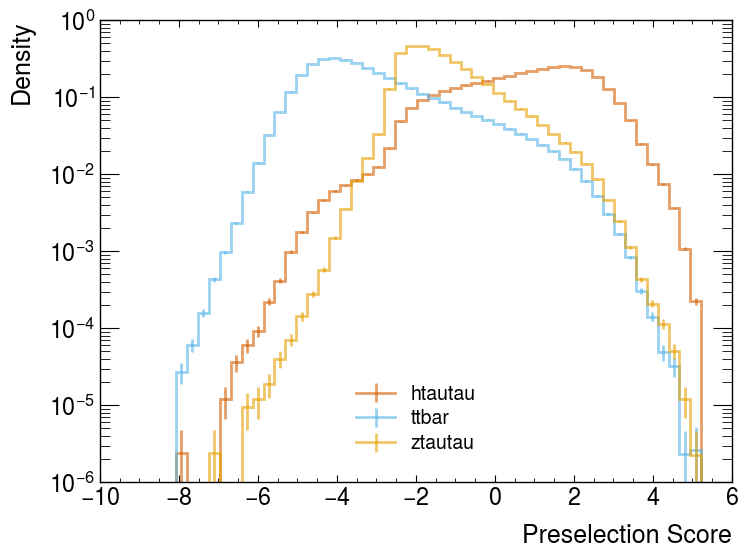

In [13]:
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=50)

hist_NN_output          = {}
hist_NN_output_errs     = {}

presel_score_arr        = {}

for sample_name, sample_dataset in dataset_incl_dict["Nominal"].items():

    presel_score_arr    = sample_dataset['presel_score']
    weights             = sample_dataset['weights']

    hist_NN_output[sample_name], _          = np.histogram(presel_score_arr, weights = weights,     bins=bins)
    
    hist_NN_output_errs[sample_name], _     = np.histogram(presel_score_arr, weights = weights**2,  bins=bins)

    hep.histplot(hist_NN_output[sample_name], bins=bins, 
             alpha=0.6, label=sample_name, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[sample_name]))

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a **Control Region** for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the **Signal Region** (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). **The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions.** 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

In [14]:
# Play around with these selections - decrease if estimators are unbiased but need more sensitivity and increase if the model is biased to reduce complexity
preselection_cuts = {'upper': 4.5, 'lower': -1.}

## Convert to an object that takes inputs - better for dynamic changing

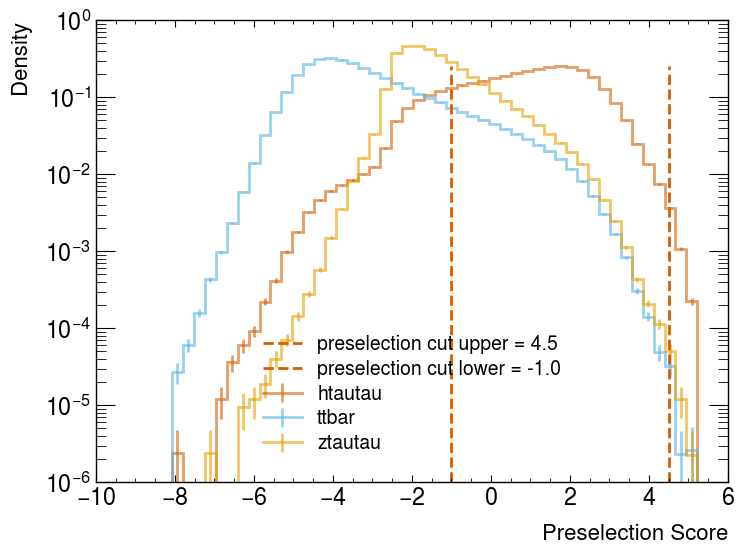

In [15]:
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = True, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=16)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=16)
plt.legend()
plt.yscale('log')
plt.show()

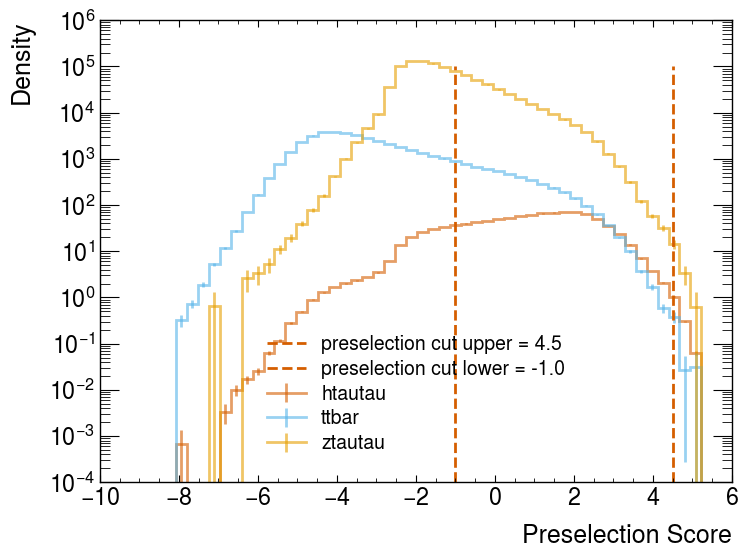

In [16]:
# Same plot as above but with un-normalized event yields
for key in train_label_sample_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = False, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Signal and Control Regions
===

The preselection cuts define the regions on which analysis is performed.

The high signal over background phase space towards the right of the *lower* preselection will be used as a signal region. But there is also low background MC statistics towards the far-right which can make trainign Neural Networks numerically unstable. As such, we define two signal regions - 

**Signal Region** is the region in the center of the lower and upper preselection cut, on which we perform unbinned NSBI analysis.

**Binned Signal Region** is the region to the right of the upper preselection cut, on which we perform binned analysis using the multi-variate observable used as the preselection score.


The low signal phase space towards the left will be used as a **Control Region**, with typical uses such as background estimation, pre-unblinding data-MC checks, etc. In this phase space, we will use a binned summary observable like in any traditional analysis.

In [25]:
regions, selections = config.get_analysis_region_cuts()

for count, region in enumerate(regions):
    print(f"{region} has selections {selections[count]}")


CR has selections presel_score<-1.0
SR_binned has selections presel_score>3.75
SR has selections presel_score>=-1.0 & presel_score<=3.75
